# Classifying Identifiable People Using Image Classification
Identify whether individuals in an image are "identifiable" or "unidentifiable". Images are considered "identifiable" if they clearly show an individual's face with no obstructions (mask, sunglasses, etc.). An applicaton of this project may be for companies that need to keep track of everyone visiting their locations.

## Building a Classification Model
### Step 1: Import Libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf

import cv2
import os

import numpy as np

### Step 2: Load the Data

In [2]:
labels = ['identifiable', 'unidentifiable']
img_size = 224

def get_data(data_dir):
    """Return a numpy array

    Numpy array containing train or testing set data values. Read the images from 
    data_dir in the RGB format and resize the images to the desired width and height.
    """
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label) # 0: identifiable, 1: unidentifiable
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype=object)

In [3]:
# Fetch the train and validation data.
train = get_data('images dataset/Training Set')
val = get_data('images dataset/Testing Set')

### Step 3: Visualize the data

<AxesSubplot:ylabel='count'>

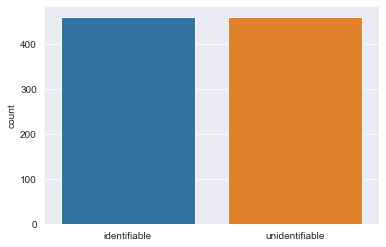

In [4]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("identifiable")
    else:
        l.append("unidentifiable")
sns.set_style('darkgrid')
sns.countplot(x=l)

Text(0.5, 1.0, 'identifiable')

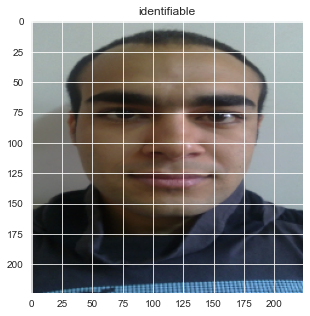

In [5]:
plt.figure(figsize = (5,5))
plt.imshow(train[1][0])
plt.title(labels[train[0][1]])

Text(0.5, 1.0, 'unidentifiable')

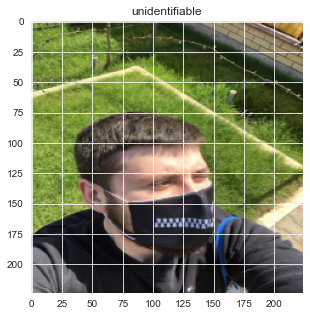

In [6]:
plt.figure(figsize = (5,5))
plt.imshow(train[-1][0])
plt.title(labels[train[-1][1]])

### Step 4: Data Preprocessing and Augmentation

In [7]:
# Preprocess the data
x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in val:
  x_val.append(feature)
  y_val.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

In [8]:
# Augment the data
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

### Step 5: Define the Model

In [9]:
# Define a simple CNN with 3 Convolutional layers followed by max-pooling layers. 
#   A dropout layer is added after the 3rd maxpool operation to avoid overfitting.
model = Sequential()
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(224,224,3)))
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(2, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 64)        0

In [10]:
# Compile the model using the Adam optimizer.
#   SparseCategoricalCrossentropy is the loss function.
#   Use a lower learning rate of 0.000001 for a smoother curve.
opt = Adam(lr=0.000001)
model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])

In [11]:
# epochs represent the number of times the model goes through the training set.
#   The model can be updated multiple times during one epoch.
#   Train the model for 500 epochs because the learning rate is so small.
#      500 epochs will produce a runtime of nearly 4 hours on a local machine.
numEpochs = 500
history = model.fit(x_train,y_train,epochs = numEpochs , validation_data = (x_val, y_val))

Epoch 1/500
29/29 [==============================] - 23s 791ms/step - loss: 0.6965 - accuracy: 0.5178 - val_loss: 0.6907 - val_accuracy: 0.5063
Epoch 2/500
29/29 [==============================] - 21s 730ms/step - loss: 0.6904 - accuracy: 0.5300 - val_loss: 0.6897 - val_accuracy: 0.5190
Epoch 3/500
29/29 [==============================] - 21s 724ms/step - loss: 0.6940 - accuracy: 0.5232 - val_loss: 0.6889 - val_accuracy: 0.5544
Epoch 4/500
29/29 [==============================] - 21s 726ms/step - loss: 0.6902 - accuracy: 0.5379 - val_loss: 0.6878 - val_accuracy: 0.5316
Epoch 5/500
29/29 [==============================] - 21s 725ms/step - loss: 0.6867 - accuracy: 0.5336 - val_loss: 0.6868 - val_accuracy: 0.5494
Epoch 6/500
29/29 [==============================] - 21s 724ms/step - loss: 0.6871 - accuracy: 0.5507 - val_loss: 0.6857 - val_accuracy: 0.5443
Epoch 7/500
29/29 [==============================] - 21s 722ms/step - loss: 0.6866 - accuracy: 0.5385 - val_loss: 0.6847 - val_accuracy:

29/29 [==============================] - 22s 744ms/step - loss: 0.5963 - accuracy: 0.7109 - val_loss: 0.6116 - val_accuracy: 0.6658
Epoch 58/500
29/29 [==============================] - 21s 742ms/step - loss: 0.5968 - accuracy: 0.7122 - val_loss: 0.6099 - val_accuracy: 0.6911
Epoch 59/500
29/29 [==============================] - 21s 732ms/step - loss: 0.5979 - accuracy: 0.6991 - val_loss: 0.6076 - val_accuracy: 0.6734
Epoch 60/500
29/29 [==============================] - 21s 727ms/step - loss: 0.5787 - accuracy: 0.7234 - val_loss: 0.6059 - val_accuracy: 0.6709
Epoch 61/500
29/29 [==============================] - 21s 737ms/step - loss: 0.5735 - accuracy: 0.7359 - val_loss: 0.6041 - val_accuracy: 0.6734
Epoch 62/500
29/29 [==============================] - 21s 727ms/step - loss: 0.5907 - accuracy: 0.6841 - val_loss: 0.6023 - val_accuracy: 0.6861
Epoch 63/500
29/29 [==============================] - 21s 726ms/step - loss: 0.5904 - accuracy: 0.7369 - val_loss: 0.6008 - val_accuracy: 0.678

29/29 [==============================] - 19s 645ms/step - loss: 0.4807 - accuracy: 0.7951 - val_loss: 0.5210 - val_accuracy: 0.7570
Epoch 114/500
29/29 [==============================] - 19s 641ms/step - loss: 0.4961 - accuracy: 0.7949 - val_loss: 0.5212 - val_accuracy: 0.7443
Epoch 115/500
29/29 [==============================] - 18s 634ms/step - loss: 0.4693 - accuracy: 0.8169 - val_loss: 0.5183 - val_accuracy: 0.7570
Epoch 116/500
29/29 [==============================] - 18s 637ms/step - loss: 0.4852 - accuracy: 0.7991 - val_loss: 0.5171 - val_accuracy: 0.7494
Epoch 117/500
29/29 [==============================] - 18s 639ms/step - loss: 0.4775 - accuracy: 0.8106 - val_loss: 0.5157 - val_accuracy: 0.7544
Epoch 118/500
29/29 [==============================] - 18s 635ms/step - loss: 0.4702 - accuracy: 0.8166 - val_loss: 0.5146 - val_accuracy: 0.7494
Epoch 119/500
29/29 [==============================] - 18s 637ms/step - loss: 0.4616 - accuracy: 0.8151 - val_loss: 0.5144 - val_accuracy:

29/29 [==============================] - 18s 639ms/step - loss: 0.4098 - accuracy: 0.8243 - val_loss: 0.4600 - val_accuracy: 0.7873
Epoch 170/500
29/29 [==============================] - 18s 638ms/step - loss: 0.4141 - accuracy: 0.8440 - val_loss: 0.4591 - val_accuracy: 0.7899
Epoch 171/500
29/29 [==============================] - 18s 636ms/step - loss: 0.3973 - accuracy: 0.8522 - val_loss: 0.4583 - val_accuracy: 0.7823
Epoch 172/500
29/29 [==============================] - 18s 635ms/step - loss: 0.4058 - accuracy: 0.8382 - val_loss: 0.4583 - val_accuracy: 0.7797
Epoch 173/500
29/29 [==============================] - 18s 635ms/step - loss: 0.4037 - accuracy: 0.8383 - val_loss: 0.4569 - val_accuracy: 0.7899
Epoch 174/500
29/29 [==============================] - 18s 634ms/step - loss: 0.4086 - accuracy: 0.8214 - val_loss: 0.4557 - val_accuracy: 0.7848
Epoch 175/500
29/29 [==============================] - 18s 634ms/step - loss: 0.3929 - accuracy: 0.8443 - val_loss: 0.4547 - val_accuracy:

29/29 [==============================] - 18s 636ms/step - loss: 0.3404 - accuracy: 0.8889 - val_loss: 0.4187 - val_accuracy: 0.8051
Epoch 226/500
29/29 [==============================] - 18s 636ms/step - loss: 0.3510 - accuracy: 0.8665 - val_loss: 0.4185 - val_accuracy: 0.8127
Epoch 227/500
29/29 [==============================] - 18s 634ms/step - loss: 0.3401 - accuracy: 0.8677 - val_loss: 0.4176 - val_accuracy: 0.8051
Epoch 228/500
29/29 [==============================] - 18s 636ms/step - loss: 0.3694 - accuracy: 0.8447 - val_loss: 0.4171 - val_accuracy: 0.8051
Epoch 229/500
29/29 [==============================] - 18s 636ms/step - loss: 0.3403 - accuracy: 0.8599 - val_loss: 0.4166 - val_accuracy: 0.8127
Epoch 230/500
29/29 [==============================] - 18s 638ms/step - loss: 0.3652 - accuracy: 0.8544 - val_loss: 0.4162 - val_accuracy: 0.8127
Epoch 231/500
29/29 [==============================] - 18s 636ms/step - loss: 0.3244 - accuracy: 0.8772 - val_loss: 0.4155 - val_accuracy:

29/29 [==============================] - 19s 641ms/step - loss: 0.3220 - accuracy: 0.8823 - val_loss: 0.3949 - val_accuracy: 0.8253
Epoch 282/500
29/29 [==============================] - 18s 637ms/step - loss: 0.2882 - accuracy: 0.9039 - val_loss: 0.3949 - val_accuracy: 0.8278
Epoch 283/500
29/29 [==============================] - 18s 636ms/step - loss: 0.3065 - accuracy: 0.9005 - val_loss: 0.3942 - val_accuracy: 0.8152
Epoch 284/500
29/29 [==============================] - 18s 636ms/step - loss: 0.3060 - accuracy: 0.8877 - val_loss: 0.3935 - val_accuracy: 0.8152
Epoch 285/500
29/29 [==============================] - 18s 636ms/step - loss: 0.3046 - accuracy: 0.8957 - val_loss: 0.3935 - val_accuracy: 0.8253
Epoch 286/500
29/29 [==============================] - 18s 634ms/step - loss: 0.3124 - accuracy: 0.8875 - val_loss: 0.3929 - val_accuracy: 0.8127
Epoch 287/500
29/29 [==============================] - 18s 634ms/step - loss: 0.3048 - accuracy: 0.8923 - val_loss: 0.3929 - val_accuracy:

29/29 [==============================] - 18s 636ms/step - loss: 0.2807 - accuracy: 0.8956 - val_loss: 0.3831 - val_accuracy: 0.8329
Epoch 338/500
29/29 [==============================] - 18s 636ms/step - loss: 0.2796 - accuracy: 0.8942 - val_loss: 0.3816 - val_accuracy: 0.8278
Epoch 339/500
29/29 [==============================] - 18s 635ms/step - loss: 0.2709 - accuracy: 0.8934 - val_loss: 0.3815 - val_accuracy: 0.8278
Epoch 340/500
29/29 [==============================] - 18s 634ms/step - loss: 0.2849 - accuracy: 0.8964 - val_loss: 0.3813 - val_accuracy: 0.8253
Epoch 341/500
29/29 [==============================] - 18s 635ms/step - loss: 0.2901 - accuracy: 0.8778 - val_loss: 0.3810 - val_accuracy: 0.8278
Epoch 342/500
29/29 [==============================] - 18s 637ms/step - loss: 0.2813 - accuracy: 0.8961 - val_loss: 0.3811 - val_accuracy: 0.8253
Epoch 343/500
29/29 [==============================] - 18s 635ms/step - loss: 0.2948 - accuracy: 0.8839 - val_loss: 0.3806 - val_accuracy:

29/29 [==============================] - 19s 640ms/step - loss: 0.2519 - accuracy: 0.9034 - val_loss: 0.3768 - val_accuracy: 0.8304
Epoch 394/500
29/29 [==============================] - 18s 636ms/step - loss: 0.2465 - accuracy: 0.9147 - val_loss: 0.3751 - val_accuracy: 0.8329
Epoch 395/500
29/29 [==============================] - 18s 636ms/step - loss: 0.2279 - accuracy: 0.9228 - val_loss: 0.3768 - val_accuracy: 0.8304
Epoch 396/500
29/29 [==============================] - 18s 637ms/step - loss: 0.2579 - accuracy: 0.9188 - val_loss: 0.3750 - val_accuracy: 0.8329
Epoch 397/500
29/29 [==============================] - 18s 637ms/step - loss: 0.2536 - accuracy: 0.8975 - val_loss: 0.3764 - val_accuracy: 0.8304
Epoch 398/500
29/29 [==============================] - 18s 636ms/step - loss: 0.2490 - accuracy: 0.9111 - val_loss: 0.3758 - val_accuracy: 0.8304
Epoch 399/500
29/29 [==============================] - 18s 638ms/step - loss: 0.2412 - accuracy: 0.9148 - val_loss: 0.3751 - val_accuracy:

29/29 [==============================] - 18s 635ms/step - loss: 0.2452 - accuracy: 0.9085 - val_loss: 0.3742 - val_accuracy: 0.8329
Epoch 450/500
29/29 [==============================] - 18s 635ms/step - loss: 0.2221 - accuracy: 0.9187 - val_loss: 0.3759 - val_accuracy: 0.8278
Epoch 451/500
29/29 [==============================] - 18s 637ms/step - loss: 0.2222 - accuracy: 0.9308 - val_loss: 0.3730 - val_accuracy: 0.8304
Epoch 452/500
29/29 [==============================] - 18s 636ms/step - loss: 0.2310 - accuracy: 0.9031 - val_loss: 0.3763 - val_accuracy: 0.8253
Epoch 453/500
29/29 [==============================] - 19s 639ms/step - loss: 0.2312 - accuracy: 0.9161 - val_loss: 0.3735 - val_accuracy: 0.8329
Epoch 454/500
29/29 [==============================] - 18s 634ms/step - loss: 0.2304 - accuracy: 0.9100 - val_loss: 0.3736 - val_accuracy: 0.8329
Epoch 455/500
29/29 [==============================] - 18s 636ms/step - loss: 0.2219 - accuracy: 0.9236 - val_loss: 0.3754 - val_accuracy:

### Step 6: Evaluate the Model

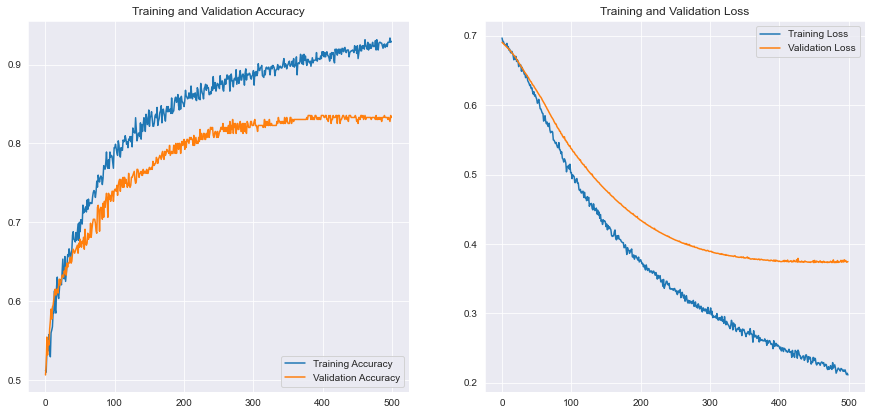

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# epochs_range is 5 beacause the previous step used 5 epochs
epochs_range = range(numEpochs)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot( epochs_range, acc, label='Training Accuracy')
plt.plot( epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [13]:
# predictions = model.predict_classes(x_val)
# above line is soon to be deprecated, is replaced with line below
predictions = np.argmax(model.predict(x_val), axis=-1)
predictions = predictions.reshape(1,-1)[0]

print(classification_report(y_val, predictions, target_names = ['Identifiable (Class 0)','Unidentifiable (Class 1)']))

                          precision    recall  f1-score   support

  Identifiable (Class 0)       0.84      0.82      0.83       197
Unidentifiable (Class 1)       0.82      0.85      0.84       198

                accuracy                           0.83       395
               macro avg       0.83      0.83      0.83       395
            weighted avg       0.83      0.83      0.83       395



## Implementing a Pre-Trained Model
### Step 1: Import the Model

In [14]:
base_model = tf.keras.applications.MobileNetV2(input_shape = (224, 224, 3), include_top = False,
                                               weights = "imagenet")

In [15]:
base_model.trainable = False

In [16]:
num_classes = 2

y_train = keras.utils.to_categorical(y_train, num_classes, dtype='int64')
y_val_original = y_val
y_val = keras.utils.to_categorical(y_val, num_classes, dtype='int64')

In [17]:
# Line Changed: tf.keras.layers.Dense(2, activation="softmax")
#   Adds a final dense layer with 2 neurons and softmax activation.
#   This led to a ValueError when calling model.fit(...):
#      ValueError: logits and labels must have the same shape ((None, 2) vs (None, 1))
#   Possible solution involves changing the dimensions of x_train, y_train, x_val, and/or y_val.
model = tf.keras.Sequential([base_model,
                                 tf.keras.layers.GlobalAveragePooling2D(),
                                 tf.keras.layers.Dropout(0.2),
                                 tf.keras.layers.Dense(num_classes, activation="softmax")                                     
                                ])

In [18]:
base_learning_rate = 0.00001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(x_train,y_train,epochs = numEpochs, validation_data = (x_val,y_val))


Epoch 1/500
29/29 [==============================] - 19s 592ms/step - loss: 0.7151 - accuracy: 0.5764 - val_loss: 0.7100 - val_accuracy: 0.5747
Epoch 2/500
29/29 [==============================] - 16s 570ms/step - loss: 0.7154 - accuracy: 0.5882 - val_loss: 0.6971 - val_accuracy: 0.6000
Epoch 3/500
29/29 [==============================] - 16s 572ms/step - loss: 0.7107 - accuracy: 0.5724 - val_loss: 0.6851 - val_accuracy: 0.6304
Epoch 4/500
29/29 [==============================] - 16s 572ms/step - loss: 0.7012 - accuracy: 0.5845 - val_loss: 0.6738 - val_accuracy: 0.6557
Epoch 5/500
29/29 [==============================] - 16s 569ms/step - loss: 0.6777 - accuracy: 0.6351 - val_loss: 0.6629 - val_accuracy: 0.6633
Epoch 6/500
29/29 [==============================] - 16s 570ms/step - loss: 0.6716 - accuracy: 0.6762 - val_loss: 0.6523 - val_accuracy: 0.6709
Epoch 7/500
29/29 [==============================] - 16s 570ms/step - loss: 0.6564 - accuracy: 0.6458 - val_loss: 0.6425 - val_accuracy:

29/29 [==============================] - 16s 566ms/step - loss: 0.3553 - accuracy: 0.9489 - val_loss: 0.3433 - val_accuracy: 0.9367
Epoch 58/500
29/29 [==============================] - 16s 569ms/step - loss: 0.3465 - accuracy: 0.9448 - val_loss: 0.3396 - val_accuracy: 0.9367
Epoch 59/500
29/29 [==============================] - 16s 569ms/step - loss: 0.3585 - accuracy: 0.9464 - val_loss: 0.3361 - val_accuracy: 0.9367
Epoch 60/500
29/29 [==============================] - 16s 569ms/step - loss: 0.3437 - accuracy: 0.9448 - val_loss: 0.3326 - val_accuracy: 0.9367
Epoch 61/500
29/29 [==============================] - 16s 569ms/step - loss: 0.3366 - accuracy: 0.9531 - val_loss: 0.3292 - val_accuracy: 0.9392
Epoch 62/500
29/29 [==============================] - 16s 568ms/step - loss: 0.3189 - accuracy: 0.9626 - val_loss: 0.3259 - val_accuracy: 0.9443
Epoch 63/500
29/29 [==============================] - 16s 573ms/step - loss: 0.3345 - accuracy: 0.9467 - val_loss: 0.3225 - val_accuracy: 0.946

29/29 [==============================] - 16s 570ms/step - loss: 0.2022 - accuracy: 0.9791 - val_loss: 0.2095 - val_accuracy: 0.9646
Epoch 114/500
29/29 [==============================] - 16s 569ms/step - loss: 0.1988 - accuracy: 0.9769 - val_loss: 0.2079 - val_accuracy: 0.9646
Epoch 115/500
29/29 [==============================] - 16s 574ms/step - loss: 0.2035 - accuracy: 0.9635 - val_loss: 0.2065 - val_accuracy: 0.9646
Epoch 116/500
29/29 [==============================] - 16s 568ms/step - loss: 0.2043 - accuracy: 0.9726 - val_loss: 0.2050 - val_accuracy: 0.9646
Epoch 117/500
29/29 [==============================] - 16s 570ms/step - loss: 0.1966 - accuracy: 0.9870 - val_loss: 0.2035 - val_accuracy: 0.9646
Epoch 118/500
29/29 [==============================] - 16s 572ms/step - loss: 0.2073 - accuracy: 0.9740 - val_loss: 0.2021 - val_accuracy: 0.9696
Epoch 119/500
29/29 [==============================] - 16s 570ms/step - loss: 0.1871 - accuracy: 0.9820 - val_loss: 0.2006 - val_accuracy:

29/29 [==============================] - 16s 567ms/step - loss: 0.1327 - accuracy: 0.9872 - val_loss: 0.1477 - val_accuracy: 0.9747
Epoch 170/500
29/29 [==============================] - 16s 571ms/step - loss: 0.1459 - accuracy: 0.9797 - val_loss: 0.1469 - val_accuracy: 0.9747
Epoch 171/500
29/29 [==============================] - 16s 568ms/step - loss: 0.1250 - accuracy: 0.9836 - val_loss: 0.1462 - val_accuracy: 0.9747
Epoch 172/500
29/29 [==============================] - 16s 570ms/step - loss: 0.1367 - accuracy: 0.9833 - val_loss: 0.1454 - val_accuracy: 0.9747
Epoch 173/500
29/29 [==============================] - 16s 568ms/step - loss: 0.1412 - accuracy: 0.9782 - val_loss: 0.1447 - val_accuracy: 0.9747
Epoch 174/500
29/29 [==============================] - 16s 571ms/step - loss: 0.1416 - accuracy: 0.9773 - val_loss: 0.1440 - val_accuracy: 0.9747
Epoch 175/500
29/29 [==============================] - 16s 570ms/step - loss: 0.1275 - accuracy: 0.9840 - val_loss: 0.1432 - val_accuracy:

29/29 [==============================] - 16s 569ms/step - loss: 0.1158 - accuracy: 0.9813 - val_loss: 0.1151 - val_accuracy: 0.9797
Epoch 226/500
29/29 [==============================] - 16s 568ms/step - loss: 0.1171 - accuracy: 0.9839 - val_loss: 0.1147 - val_accuracy: 0.9797
Epoch 227/500
29/29 [==============================] - 16s 573ms/step - loss: 0.0992 - accuracy: 0.9816 - val_loss: 0.1143 - val_accuracy: 0.9797
Epoch 228/500
29/29 [==============================] - 16s 569ms/step - loss: 0.0978 - accuracy: 0.9826 - val_loss: 0.1139 - val_accuracy: 0.9797
Epoch 229/500
29/29 [==============================] - 16s 570ms/step - loss: 0.1055 - accuracy: 0.9843 - val_loss: 0.1135 - val_accuracy: 0.9797
Epoch 230/500
29/29 [==============================] - 16s 568ms/step - loss: 0.1008 - accuracy: 0.9854 - val_loss: 0.1131 - val_accuracy: 0.9797
Epoch 231/500
29/29 [==============================] - 17s 575ms/step - loss: 0.1036 - accuracy: 0.9848 - val_loss: 0.1127 - val_accuracy:

29/29 [==============================] - 16s 568ms/step - loss: 0.0861 - accuracy: 0.9828 - val_loss: 0.0965 - val_accuracy: 0.9823
Epoch 282/500
29/29 [==============================] - 16s 572ms/step - loss: 0.0945 - accuracy: 0.9861 - val_loss: 0.0963 - val_accuracy: 0.9823
Epoch 283/500
29/29 [==============================] - 16s 569ms/step - loss: 0.0953 - accuracy: 0.9820 - val_loss: 0.0960 - val_accuracy: 0.9823
Epoch 284/500
29/29 [==============================] - 16s 567ms/step - loss: 0.0822 - accuracy: 0.9890 - val_loss: 0.0958 - val_accuracy: 0.9823
Epoch 285/500
29/29 [==============================] - 16s 568ms/step - loss: 0.0855 - accuracy: 0.9852 - val_loss: 0.0955 - val_accuracy: 0.9823
Epoch 286/500
29/29 [==============================] - 16s 573ms/step - loss: 0.0774 - accuracy: 0.9857 - val_loss: 0.0953 - val_accuracy: 0.9823
Epoch 287/500
29/29 [==============================] - 16s 567ms/step - loss: 0.0842 - accuracy: 0.9901 - val_loss: 0.0950 - val_accuracy:

29/29 [==============================] - 16s 571ms/step - loss: 0.0693 - accuracy: 0.9871 - val_loss: 0.0851 - val_accuracy: 0.9823
Epoch 338/500
29/29 [==============================] - 16s 570ms/step - loss: 0.0673 - accuracy: 0.9923 - val_loss: 0.0849 - val_accuracy: 0.9823
Epoch 339/500
29/29 [==============================] - 16s 569ms/step - loss: 0.0667 - accuracy: 0.9874 - val_loss: 0.0848 - val_accuracy: 0.9823
Epoch 340/500
29/29 [==============================] - 16s 569ms/step - loss: 0.0751 - accuracy: 0.9877 - val_loss: 0.0846 - val_accuracy: 0.9823
Epoch 341/500
29/29 [==============================] - 16s 571ms/step - loss: 0.0784 - accuracy: 0.9836 - val_loss: 0.0845 - val_accuracy: 0.9823
Epoch 342/500
29/29 [==============================] - 17s 574ms/step - loss: 0.0741 - accuracy: 0.9885 - val_loss: 0.0843 - val_accuracy: 0.9823
Epoch 343/500
29/29 [==============================] - 16s 568ms/step - loss: 0.0704 - accuracy: 0.9870 - val_loss: 0.0842 - val_accuracy:

29/29 [==============================] - 16s 568ms/step - loss: 0.0747 - accuracy: 0.9803 - val_loss: 0.0777 - val_accuracy: 0.9848
Epoch 394/500
29/29 [==============================] - 16s 568ms/step - loss: 0.0504 - accuracy: 0.9929 - val_loss: 0.0775 - val_accuracy: 0.9848
Epoch 395/500
29/29 [==============================] - 16s 569ms/step - loss: 0.0696 - accuracy: 0.9890 - val_loss: 0.0774 - val_accuracy: 0.9848
Epoch 396/500
29/29 [==============================] - 16s 568ms/step - loss: 0.0569 - accuracy: 0.9922 - val_loss: 0.0773 - val_accuracy: 0.9848
Epoch 397/500
29/29 [==============================] - 16s 572ms/step - loss: 0.0816 - accuracy: 0.9833 - val_loss: 0.0772 - val_accuracy: 0.9848
Epoch 398/500
29/29 [==============================] - 16s 567ms/step - loss: 0.0671 - accuracy: 0.9883 - val_loss: 0.0771 - val_accuracy: 0.9848
Epoch 399/500
29/29 [==============================] - 16s 569ms/step - loss: 0.0716 - accuracy: 0.9884 - val_loss: 0.0770 - val_accuracy:

29/29 [==============================] - 16s 568ms/step - loss: 0.0614 - accuracy: 0.9882 - val_loss: 0.0724 - val_accuracy: 0.9848
Epoch 450/500
29/29 [==============================] - 16s 567ms/step - loss: 0.0566 - accuracy: 0.9883 - val_loss: 0.0724 - val_accuracy: 0.9848
Epoch 451/500
29/29 [==============================] - 16s 572ms/step - loss: 0.0552 - accuracy: 0.9880 - val_loss: 0.0723 - val_accuracy: 0.9848
Epoch 452/500
29/29 [==============================] - 16s 574ms/step - loss: 0.0765 - accuracy: 0.9877 - val_loss: 0.0721 - val_accuracy: 0.9848
Epoch 453/500
29/29 [==============================] - 16s 568ms/step - loss: 0.0579 - accuracy: 0.9872 - val_loss: 0.0721 - val_accuracy: 0.9848
Epoch 454/500
29/29 [==============================] - 16s 569ms/step - loss: 0.0523 - accuracy: 0.9933 - val_loss: 0.0720 - val_accuracy: 0.9848
Epoch 455/500
29/29 [==============================] - 16s 570ms/step - loss: 0.0552 - accuracy: 0.9916 - val_loss: 0.0720 - val_accuracy:

### Step 2: Evaluating the result

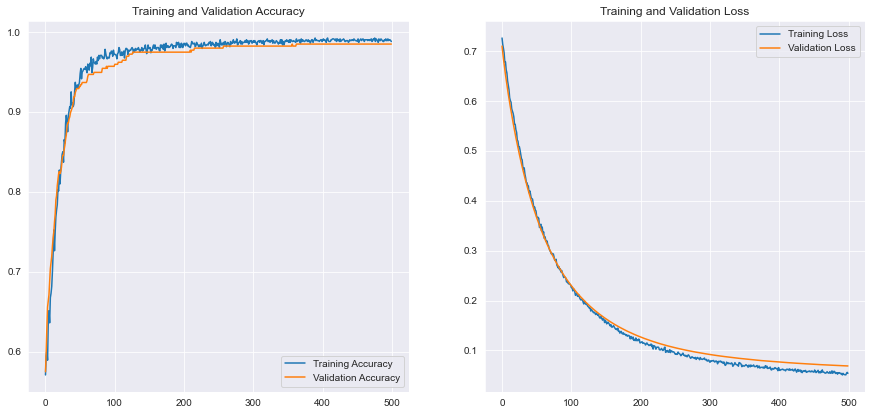

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(numEpochs)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
predictions = np.argmax(model.predict(x_val), axis=-1)
predictions = predictions.reshape(1,-1)[0]

print(classification_report(y_val_original, predictions, target_names = ['Identifiable (Class 0)','Unidentifiable (Class 1)']))

                          precision    recall  f1-score   support

  Identifiable (Class 0)       0.98      0.98      0.98       197
Unidentifiable (Class 1)       0.98      0.98      0.98       198

                accuracy                           0.98       395
               macro avg       0.98      0.98      0.98       395
            weighted avg       0.98      0.98      0.98       395



### Saving and Loading Model

In [21]:
# Saving Model
model.save('saved_model/model_v1')

# Loading Model
new_model = tf.keras.models.load_model('saved_model/model_v1')

# Checking Loaded Model
saved_predictions = np.argmax(new_model.predict(x_val), axis=-1)
saved_predictions = saved_predictions.reshape(1,-1)[0]

print(classification_report(y_val_original, saved_predictions, target_names = ['Identifiable (Class 0)','Unidentifiable (Class 1)']))

INFO:tensorflow:Assets written to: saved_model/model_v1\assets
                          precision    recall  f1-score   support

  Identifiable (Class 0)       0.98      0.98      0.98       197
Unidentifiable (Class 1)       0.98      0.98      0.98       198

                accuracy                           0.98       395
               macro avg       0.98      0.98      0.98       395
            weighted avg       0.98      0.98      0.98       395

